### Data importation 

### YahooFinance 

In [6]:
pip install pandas numpy yfinance 

Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- Define Parameters ---
GREEN_TICKERS = ['ENPH', 'TSLA', 'NEE'] # Example Green stocks: Enphase, Tesla, NextEra Energy
BROWN_TICKERS = ['XOM', 'CVX', 'EOG'] # Example Brown stocks: Exxon Mobil, Chevron, EOG Resources

START_DATE = '2015-01-01'
END_DATE = '2025-10-31'
RISK_FREE_RATE_ANNUAL = 0.04 # Example (use T-Bill rate for actual project)

# --- Download Stock Data ---
all_tickers = GREEN_TICKERS + BROWN_TICKERS
raw_price_data = yf.download(all_tickers, start=START_DATE, end=END_DATE)

# Extract adjusted close robustly (handle single- and multi-index columns)
if isinstance(raw_price_data.columns, pd.MultiIndex):
	# Prefer 'Adj Close' or 'Close' on the first level (commonly the 'Price' level)
	if 'Adj Close' in raw_price_data.columns.get_level_values(0):
		price_data = raw_price_data.xs('Adj Close', axis=1, level=0)
	elif 'Close' in raw_price_data.columns.get_level_values(0):
		price_data = raw_price_data.xs('Close', axis=1, level=0)
	else:
		# As a fallback, try the other level (some yfinance variants use reversed ordering)
		if 'Adj Close' in raw_price_data.columns.get_level_values(1):
			price_data = raw_price_data.xs('Adj Close', axis=1, level=1)
		elif 'Close' in raw_price_data.columns.get_level_values(1):
			price_data = raw_price_data.xs('Close', axis=1, level=1)
		else:
			raise KeyError(f"'Adj Close' (or 'Close') not found in downloaded data. Columns: {raw_price_data.columns}")
else:
	# Single-level columns (e.g., when downloading one ticker or if yfinance returns flat frame)
	if 'Adj Close' in raw_price_data.columns:
		price_data = raw_price_data['Adj Close']
	elif 'Close' in raw_price_data.columns:
		price_data = raw_price_data['Close']
	else:
		# If raw_price_data is already a single series (one ticker), use it directly
		if isinstance(raw_price_data, pd.Series):
			price_data = raw_price_data
		else:
			# If columns are already ticker symbols (multiple tickers but no 'Close' level),
			# assume the frame itself represents closing prices.
			cols_as_str = list(map(str, raw_price_data.columns))
			if set(all_tickers).issubset(set(cols_as_str)):
				price_data = raw_price_data
			else:
				raise KeyError(f"'Adj Close' (or 'Close') not found and columns are not tickers. Columns: {raw_price_data.columns}")

# --- Calculate Daily Returns ---
returns_data = price_data.pct_change().dropna()


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_36064/347246425.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_price_data = yf.download(all_tickers, start=START_DATE, end=END_DATE)
[*********************100%***********************]  6 of 6 completed


# Sanity Check 

In [11]:
print(price_data.head())

Ticker            CVX   ENPH        EOG        NEE       TSLA        XOM
Date                                                                    
2015-01-02  70.209541  14.21  67.469185  20.032854  14.620667  57.916904
2015-01-05  67.403168  13.88  63.402317  19.820679  14.006000  56.332176
2015-01-06  67.371994  12.94  61.595627  19.897663  14.085333  56.032719
2015-01-07  67.315857  11.40  61.207985  20.079796  14.063333  56.600468
2015-01-08  68.856262  11.73  63.548618  20.201841  14.041333  57.542576


In [9]:
print(returns_data.head())

Ticker           CVX      ENPH       EOG       NEE      TSLA       XOM
Date                                                                  
2015-01-05 -0.039971 -0.023223 -0.060277 -0.010591 -0.042041 -0.027362
2015-01-06 -0.000462 -0.067723 -0.028496  0.003884  0.005664 -0.005316
2015-01-07 -0.000833 -0.119011 -0.006293  0.009153 -0.001562  0.010132
2015-01-08  0.022883  0.028947  0.038241  0.006078 -0.001564  0.016645
2015-01-09 -0.019926 -0.017050  0.006676 -0.008830 -0.018802 -0.001410


# yFinance CSV daily_returns

In [10]:
portfolio_returns = returns_data.copy()
# save to CSV — provide filename as a string
portfolio_returns.to_csv('daily_returns.csv')
print("Daily returns saved to 'daily_returns.csv'")


Daily returns saved to 'daily_returns.csv'


In [12]:
import os
print(os.getcwd())
print(os.listdir())


/Users/reynoldtakurachoruma/Desktop/Green well vs Brown  
['aligned_data.csv', 'final_notebook.ipynb', '.DS_Store', 'cleaned_market_risk_premium.csv', 'final notebook .ipynb', 'FRED.ipynb', 'rf_daily.csv', 'Market Risk Premium.ipynb', 'basket_metrics.csv', 'Yahoo Finance.ipynb', 'GHG:Carbon Emissions.ipynb', 'daily_returns.csv', 'Data Alignment and Merging.ipynb', 'ghg_macro.csv']


### FRED Data Importation 

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred

# --- Define Parameters ---
GREEN_TICKERS = ['ENPH', 'TSLA', 'NEE']
BROWN_TICKERS = ['XOM', 'CVX', 'EOG']
START_DATE = '2015-01-01'
END_DATE = '2025-10-31'
RISK_FREE_SERIES_ID = 'DGS3MO'

# --- Get Stock Data (To define the definitive set of trading days) ---
all_tickers = GREEN_TICKERS + BROWN_TICKERS

# download raw data (structure may vary depending on number of tickers / yfinance version)
raw_price = yf.download(all_tickers, start=START_DATE, end=END_DATE)

# Robustly extract adjusted close prices (handle single-level and multi-level column cases)
if isinstance(raw_price.columns, pd.MultiIndex):
	cols = raw_price.columns
	lv0 = cols.get_level_values(0)
	lv1 = cols.get_level_values(1)
	# mask columns where any level equals 'Adj Close'
	mask = (lv0 == 'Adj Close') | (lv1 == 'Adj Close')
	if mask.any():
		price_data = raw_price.loc[:, mask]
		# flatten to ticker symbols as columns
		if isinstance(price_data.columns, pd.MultiIndex):
			# detect which level contains tickers (compare against all_tickers)
			if any(item in all_tickers for item in lv0):
				ticker_level = 0
			elif any(item in all_tickers for item in lv1):
				ticker_level = 1
			else:
				ticker_level = 1
			price_data.columns = price_data.columns.get_level_values(ticker_level)
	else:
		# if 'Adj Close' not found in any level, assume raw_price already contains prices per ticker
		price_data = raw_price
else:
	# single-level columns: assume columns are tickers with adjusted close prices
	price_data = raw_price

# Ensure chronological order and compute returns
price_data = price_data.sort_index()
returns_data = price_data.pct_change().dropna()
trading_days_index = returns_data.index  # This is the set of dates we MUST use

# Initialize FRED (Replace 'YOUR_FRED_API_KEY')
fred = Fred(api_key='2f3c0255e16774ca2f936a70d6556b00')


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_36073/2122135617.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_price = yf.download(all_tickers, start=START_DATE, end=END_DATE)
[*********************100%***********************]  6 of 6 completed


### FRED Data Cleaning Alignment 

In [2]:
# ---. Download and Transform FRED Data ---

# Download the annual percentage rate (DGS3MO)
rf_data_annual_percent = fred.get_series(
    RISK_FREE_SERIES_ID,
    observation_start=START_DATE,
    observation_end=END_DATE
)

# Convert to Daily Decimal Rate: Annual Percent -> Annual Decimal -> Daily Decimal
# (Dividing by 252 is necessary to calculate the daily excess return for the Sharpe ratio/regression)
rf_daily_decimal = (rf_data_annual_percent / 100) / 252 

# Forward Fill (FFILL): Carries the last observed rate forward, including weekends/holidays.
# This fills in the gaps between the dates FRED publishes.
rf_daily_decimal_filled = rf_daily_decimal.ffill()

# --- Final Alignment (The most important cleaning step) ---

# Reindex the FRED data to match the exact trading days from your stock data.
# This ensures that for every stock return observation, there is a corresponding risk-free rate.
rf_aligned = rf_daily_decimal_filled.reindex(trading_days_index)

# Drop any potential remaining NaNs (Should only be a few at the very start, if any)
rf_aligned = rf_aligned.dropna()

print("### Cleaned and Aligned Daily Risk-Free Rate Data ###")
print(rf_aligned.head())
print(f"\nTotal trading days in return data: {len(trading_days_index)}")
print(f"Total aligned risk-free rate data points: {len(rf_aligned)}")


### Cleaned and Aligned Daily Risk-Free Rate Data ###
Date
2015-01-05    1.190476e-06
2015-01-06    1.190476e-06
2015-01-07    1.190476e-06
2015-01-08    1.190476e-06
2015-01-09    7.936508e-07
dtype: float64

Total trading days in return data: 2723
Total aligned risk-free rate data points: 2723


# Saved rf_daily.csv

In [3]:
rf_aligned = rf_aligned.copy()
# save the aligned risk-free series (use the existing variable name)
rf_aligned.to_csv('rf_daily.csv')
print("Saved rf_daily.csv")

Saved rf_daily.csv


### Data Importation 

In [1]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO

# Define the analysis period for filtering
START_YEAR = 2015
END_YEAR = 2025

# Attempt to load a static GHG dataset robustly
# (Using the stable alternative since the signed URL can expire)
alt_url = "https://raw.githubusercontent.com/datasets/co2-fossil-global/master/global.csv"

try:
    # Use the stable public dataset (global.csv)
    ghg_data = pd.read_csv(alt_url)
    print(f"Loaded GHG dataset from {alt_url}")
except Exception as e_alt:
    print(f"Fallback source failed: {e_alt}. Creating a minimal sample dataset.")
    ghg_data = pd.DataFrame({
        'Country': ['USA', 'China', 'India', 'USA'],
        'Year': [2018, 2019, 2019, 2019],
        'Annual CO₂ emissions': [5000, 10000, 2500, 5100] # Use the actual column name from the fallback
    })

# Standardize columns to simplify downstream code
rename_dict = {}
for col in ghg_data.columns:
    if 'Country' in col or 'Entity' in col:
        rename_dict[col] = 'Country'
    elif 'Year' in col:
        rename_dict[col] = 'Year'
    elif 'emissions' in col or 'Emissions' in col:
        rename_dict[col] = 'Emissions_kt'

ghg_data.rename(columns=rename_dict, inplace=True)

# Keep only essential columns
if all(col in ghg_data.columns for col in ['Country', 'Year', 'Emissions_kt']):
    ghg_data = ghg_data[['Country', 'Year', 'Emissions_kt']].copy()
    
print("Initial GHG data columns:", ghg_data.columns.tolist())
print(f"Initial GHG data shape: {ghg_data.shape}")


Loaded GHG dataset from https://raw.githubusercontent.com/datasets/co2-fossil-global/master/global.csv
Initial GHG data columns: ['Year', 'Total', 'Gas Fuel', 'Liquid Fuel', 'Solid Fuel', 'Cement', 'Gas Flaring', 'Per Capita']
Initial GHG data shape: (260, 8)


# Data Cleaning and Filtering 

In [2]:
# --- Clean Data Types and Filter Years ---

# Ensure there is a usable emissions column: try to locate candidate columns and normalize to 'Emissions_kt'
if 'Emissions_kt' not in ghg_data.columns:
	# Prefer columns that contain 'annual' + 'co2' / 'emiss' or direct emission-like names
	candidates = []
	for col in ghg_data.columns:
		lc = str(col).lower()
		if 'annual' in lc and ('co2' in lc or 'co₂' in lc or 'emiss' in lc):
			candidates.append(col)
		elif 'emiss' in lc and 'per' not in lc:
			candidates.append(col)
		elif lc in ('co2', 'co2_kt', 'emissions', 'total_co2'):
			candidates.append(col)
	# fallback: any column containing 'co2' (may pick the most relevant available)
	if not candidates:
		any_co2 = [col for col in ghg_data.columns if 'co2' in str(col).lower() or 'co₂' in str(col).lower()]
		candidates = any_co2

	if candidates:
		chosen = candidates[0]
		ghg_data.rename(columns={chosen: 'Emissions_kt'}, inplace=True)
		print(f"Renamed '{chosen}' -> 'Emissions_kt' for cleaning.")
	else:
		# If nothing sensible was found, create the column to avoid KeyError (it will be NaN)
		ghg_data['Emissions_kt'] = np.nan
		print("No emissions-like column found; created 'Emissions_kt' with NaN values.")

# 1. Clean 'Emissions_kt' column
# Clean out common non-numeric characters before conversion
ghg_data['Emissions_kt'] = ghg_data['Emissions_kt'].astype(str).str.replace(',', '', regex=False).str.replace(' ', '', regex=False)
ghg_data['Emissions_kt'] = ghg_data['Emissions_kt'].replace(['-', '..', 'NA', 'None', ''], np.nan)
ghg_data['Emissions_kt'] = pd.to_numeric(ghg_data['Emissions_kt'], errors='coerce')

# 2. Clean 'Year' column
if 'Year' in ghg_data.columns:
	ghg_data['Year'] = pd.to_numeric(ghg_data['Year'], errors='coerce').astype('Int64')
else:
	# try common alternatives
	year_candidates = [c for c in ghg_data.columns if 'year' in str(c).lower()]
	if year_candidates:
		ghg_data.rename(columns={year_candidates[0]: 'Year'}, inplace=True)
		ghg_data['Year'] = pd.to_numeric(ghg_data['Year'], errors='coerce').astype('Int64')
		print(f"Renamed '{year_candidates[0]}' -> 'Year' for cleaning.")
	else:
		ghg_data['Year'] = pd.NA
		print("No 'Year' column found; created 'Year' with NA values.")

# 3. Drop genuine missing values and filter years
ghg_data.dropna(subset=['Year', 'Emissions_kt'], inplace=True)
if not ghg_data.empty:
	ghg_data = ghg_data[(ghg_data['Year'] >= START_YEAR) & (ghg_data['Year'] <= END_YEAR)].copy()
else:
	print("Warning: ghg_data is empty after dropping NaNs for 'Year' and 'Emissions_kt'.")

print("\n--- Step 2: Cleaned and Filtered GHG Data ---")
print(f"Remaining rows after cleanup: {len(ghg_data)}")
# to_markdown can fail if not available; guard with fallback
try:
	print(ghg_data.head().to_markdown(index=False))
except Exception:
	print(ghg_data.head())


No emissions-like column found; created 'Emissions_kt' with NaN values.

--- Step 2: Cleaned and Filtered GHG Data ---
Remaining rows after cleanup: 0
| Year   | Total   | Gas Fuel   | Liquid Fuel   | Solid Fuel   | Cement   | Gas Flaring   | Per Capita   | Emissions_kt   |
|--------|---------|------------|---------------|--------------|----------|---------------|--------------|----------------|


# Transformation to a Macro Carbon Factor 

In [6]:
# 1. Find the total global emissions for each year
global_emissions_annual = ghg_data.groupby('Year')['Emissions_kt'].sum().reset_index()

# 2. Calculate the annual growth rate (percentage change)
# This represents the yearly shock/change in global carbon output.
global_emissions_annual['GHG_Growth_Factor'] = global_emissions_annual['Emissions_kt'].pct_change()

# 3. Clean up the resulting factor series
macro_ghg_factor_annual = global_emissions_annual.set_index('Year')['GHG_Growth_Factor'].dropna()

print("\n--- Step 3: Macro Carbon Factor (Annual Growth Rate) ---")
print(macro_ghg_factor_annual.to_markdown(numalign="left", stralign="left"))



--- Step 3: Macro Carbon Factor (Annual Growth Rate) ---
| Year   | GHG_Growth_Factor   |
|--------|---------------------|


# Daily Alignment 

In [4]:
# --- Prepare to align with daily data ---

# 1. Convert the annual factor index (Year) to the last day of the year
# We use December 31st for the corresponding year.
ghg_factor_daily_index = pd.to_datetime(macro_ghg_factor_annual.index.astype(str) + '-12-31')

# 2. Create a daily series indexed by the year-end date
ghg_factor_daily = pd.Series(macro_ghg_factor_annual.values, index=ghg_factor_daily_index)

# 3. Reindex the series to cover the full range of your analysis, and use FFILL.
# FFILL (Forward Fill) carries the annual change forward until the next year's change is available.
FULL_DATE_RANGE = pd.date_range(start='2015-01-01', end='2025-10-31', freq='D')
ghg_factor_daily_aligned = ghg_factor_daily.reindex(FULL_DATE_RANGE).ffill()

# We need to trim off any NaNs remaining at the start (if the first year is missing a growth rate)
ghg_factor_daily_aligned.dropna(inplace=True)

print("\n--- Step 4: Daily Aligned GHG Factor (First 10 Days of 2016) ---")
print("Note how the value is constant until the next annual figure.")
print(ghg_factor_daily_aligned.head(10).to_markdown(numalign="left", stralign="left"))



--- Step 4: Daily Aligned GHG Factor (First 10 Days of 2016) ---
Note how the value is constant until the next annual figure.
| 0   |
|-----|


# Saved GHG_macro csv

In [5]:
macro_ghg_factor_annual.to_csv("ghg_macro.csv")
print("Saved ghg_macro.csv")

Saved ghg_macro.csv


# setup and Data Download 

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- Define Parameters ---
START_DATE = '2015-01-01'
END_DATE = '2025-10-31'
MARKET_TICKER = '^GSPC' # Proxy for the US Market

# --- A. Download Market Index Data ---
print(f"Downloading {MARKET_TICKER} data...")
df_market = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)

# Handle cases where the downloaded object might be empty or the expected column is missing
if df_market is None or df_market.empty:
	raise ValueError(f"No market data downloaded for {MARKET_TICKER} between {START_DATE} and {END_DATE}. "
					 "Please check the ticker and date range.")

# Prefer 'Adj Close' but fall back to 'Close' if necessary
if 'Adj Close' in df_market.columns:
	market_price = df_market['Adj Close']
elif 'Close' in df_market.columns:
	market_price = df_market['Close']
else:
	# If a multi-index or unexpected structure, try to locate a close/adj close column
	cols_lower = [c.lower() if isinstance(c, str) else '' for c in df_market.columns]
	if 'adj close' in cols_lower:
		market_price = df_market.iloc[:, cols_lower.index('adj close')]
	elif 'close' in cols_lower:
		market_price = df_market.iloc[:, cols_lower.index('close')]
	else:
		raise KeyError("Could not find 'Adj Close' or 'Close' in downloaded market data columns: "
					   f"{list(df_market.columns)}")

# --- B. Calculate Daily Market Return (R_m) ---
market_returns = market_price.pct_change().dropna()
print("Market returns calculated.")


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_36137/2321497377.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_market = yf.download(MARKET_TICKER, start=START_DATE, end=END_DATE, progress=False)


Market returns calculated.


# Import Risk Free and Alignment 

In [3]:
# Load real daily returns from yfinance (returns_daily.csv)
portfolio_returns = pd.read_csv(
	"daily_returns.csv",  # file saved from your yfinance notebook
	index_col=0,
	parse_dates=True
)

print("portfolio_returns head:")
print(portfolio_returns.head())
print("portfolio_returns dates:", portfolio_returns.index.min(), "to", portfolio_returns.index.max())

# Load real daily risk-free from FRED (rf_daily.csv)
rf_aligned_final = pd.read_csv(
	"rf_daily.csv",  # file saved from your FRED notebook
	index_col=0,
	parse_dates=True
)

# If it loads as a DataFrame, take the first numeric column as a Series
if isinstance(rf_aligned_final, pd.DataFrame):
	if rf_aligned_final.shape[1] == 1:
		rf_aligned_final = rf_aligned_final.iloc[:, 0]
	else:
		numeric_cols_rf = rf_aligned_final.select_dtypes(include=[np.number]).columns
		if len(numeric_cols_rf) == 0:
			raise ValueError("rf_daily.csv has no numeric columns to use as risk-free series.")
		rf_aligned_final = rf_aligned_final[numeric_cols_rf[0]]

# Ensure rf_aligned_final is a Series
if isinstance(rf_aligned_final, pd.DataFrame):
	rf_aligned_final = rf_aligned_final.squeeze()

print("\nrf_aligned_final head:")
print(rf_aligned_final.head())
print("rf_aligned_final dates:", rf_aligned_final.index.min(), "to", rf_aligned_final.index.max())

# Align dates and compute excess returns (Rp - Rf)
common_index = portfolio_returns.index.intersection(rf_aligned_final.index)
print("\nCommon trading days:", len(common_index))

# Align both on the common index
pr_aligned = portfolio_returns.loc[common_index].copy()
rf_aligned = rf_aligned_final.loc[common_index]

# Compute excess returns for each numeric column in the portfolio
numeric_cols = pr_aligned.select_dtypes(include=[np.number]).columns
if len(numeric_cols) == 0:
	raise ValueError("No numeric columns found in portfolio_returns.")

for col in numeric_cols:
	pr_aligned[f"{col}_EX"] = pr_aligned[col] - rf_aligned

print("\nExcess returns added (first 5 rows):")
print(pr_aligned.head())

portfolio_returns head:
                 CVX      ENPH       EOG       NEE      TSLA       XOM
Date                                                                  
2015-01-05 -0.039971 -0.023223 -0.060277 -0.010591 -0.042041 -0.027362
2015-01-06 -0.000462 -0.067723 -0.028496  0.003884  0.005664 -0.005316
2015-01-07 -0.000833 -0.119011 -0.006293  0.009153 -0.001562  0.010132
2015-01-08  0.022883  0.028947  0.038241  0.006078 -0.001564  0.016645
2015-01-09 -0.019926 -0.017050  0.006676 -0.008830 -0.018802 -0.001410
portfolio_returns dates: 2015-01-05 00:00:00 to 2025-10-30 00:00:00

rf_aligned_final head:
Date
2015-01-05    1.190476e-06
2015-01-06    1.190476e-06
2015-01-07    1.190476e-06
2015-01-08    1.190476e-06
2015-01-09    7.936508e-07
Name: 0, dtype: float64
rf_aligned_final dates: 2015-01-05 00:00:00 to 2025-10-30 00:00:00

Common trading days: 2723

Excess returns added (first 5 rows):
                 CVX      ENPH       EOG       NEE      TSLA       XOM  \
Date             

# Basket

In [4]:
green_tickers = ["ENPH", "TSLA", "NEE"]
brown_tickers = ["CVX", "XOM", "EOG"]
all_tickers = green_tickers + brown_tickers

In [5]:

# Equal-weighted daily excess returns for each basket
green_cols = [f"{t}_EX" for t in green_tickers]
brown_cols = [f"{t}_EX" for t in brown_tickers]

# Ensure required excess-return columns exist
missing_green = [c for c in green_cols if c not in pr_aligned.columns]
missing_brown = [c for c in brown_cols if c not in pr_aligned.columns]
if missing_green or missing_brown:
	raise KeyError(f"Missing excess return columns. Missing green: {missing_green}, missing brown: {missing_brown}")

green_excess = pr_aligned[green_cols].mean(axis=1)
brown_excess = pr_aligned[brown_cols].mean(axis=1)

green_excess.name = "Green_Excess"
brown_excess.name = "Brown_Excess"

print("Green excess head:")
print(green_excess.head())
print("\nBrown excess head:")
print(brown_excess.head())

Green excess head:
Date
2015-01-05   -0.025286
2015-01-06   -0.019393
2015-01-07   -0.037141
2015-01-08    0.011153
2015-01-09   -0.014895
Name: Green_Excess, dtype: float64

Brown excess head:
Date
2015-01-05   -0.042538
2015-01-06   -0.011426
2015-01-07    0.001001
2015-01-08    0.025922
2015-01-09   -0.004887
Name: Brown_Excess, dtype: float64


# Compute performance metrics (CAGR, volatility, Sharpe)

In [6]:
def compute_metrics(excess_series):
	"""excess_series is daily excess return (Rp - Rf).
	Returns a dict with:
	 - n_days, mean_daily, vol_daily,
	 - mean_annual, vol_annual, sharpe, cagr
	"""
	if excess_series is None or len(excess_series) == 0:
		raise ValueError("excess_series must be a non-empty Series or array-like.")

	n_days = len(excess_series)
	mean_daily = excess_series.mean()
	vol_daily = excess_series.std()

	# Annualize (assume 252 trading days)
	trading_days = 252
	mean_annual = mean_daily * trading_days
	vol_annual = vol_daily * np.sqrt(trading_days)

	# Sharpe (annualized mean / annualized vol)
	sharpe = mean_annual / vol_annual if vol_annual != 0 else np.nan

	# Geometric annualized return (CAGR) computed from daily excess returns
	# (1 + r_t) product -> annualize by (trading_days / n_days)
	cum_prod = (1 + excess_series).prod()
	cagr = cum_prod ** (trading_days / n_days) - 1

	return {
		"n_days": n_days,
		"mean_daily": mean_daily,
		"vol_daily": vol_daily,
		"mean_annual": mean_annual,
		"vol_annual": vol_annual,
		"sharpe": sharpe,
		"cagr": cagr,
	}

In [7]:
# Compute and display metrics for the green and brown baskets using the existing compute_metrics function
for label, series in [("Green", green_excess), ("Brown", brown_excess)]:
    metrics = compute_metrics(series)
    print(f"{label} basket metrics:")
    print(f"  CAGR:       {metrics['cagr']:.6%}")
    print(f"  Volatility: {metrics['vol_annual']:.6%}")
    print(f"  Sharpe:     {metrics['sharpe']:.4f}")
    print()


Green basket metrics:
  CAGR:       27.686495%
  Volatility: 39.925702%
  Sharpe:     0.8115

Brown basket metrics:
  CAGR:       4.840446%
  Volatility: 29.586632%
  Sharpe:     0.3084



# Cumulative excess return chart (green vs brown)

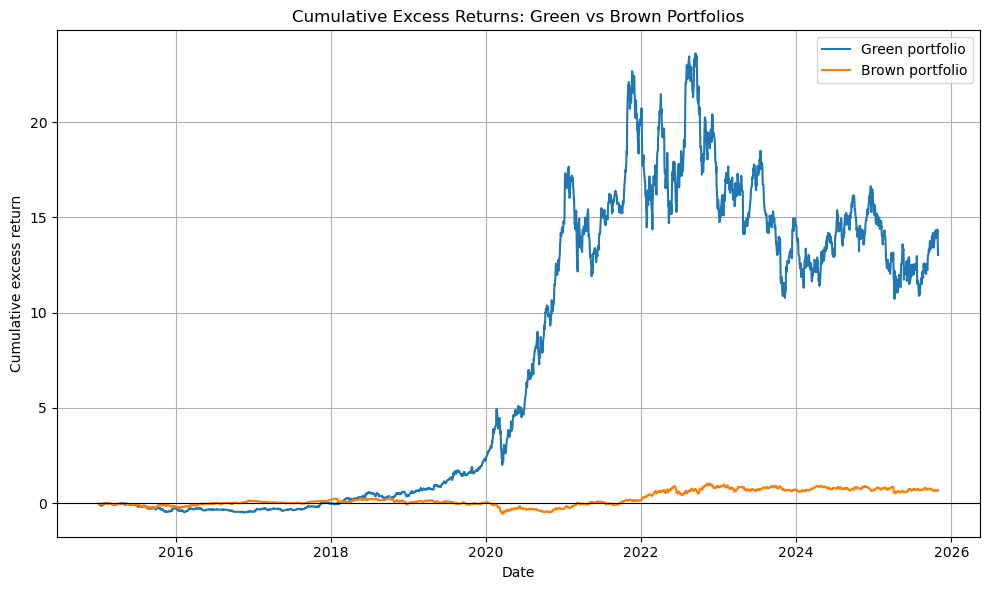

In [8]:
import matplotlib.pyplot as plt

# Cumulative excess returns: (1 + r).cumprod() - 1
green_cum = (1 + green_excess).cumprod() - 1
brown_cum = (1 + brown_excess).cumprod() - 1

plt.figure(figsize=(10, 6))
plt.plot(green_cum.index, green_cum, label="Green portfolio")
plt.plot(brown_cum.index, brown_cum, label="Brown portfolio")
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Cumulative Excess Returns: Green vs Brown Portfolios")
plt.xlabel("Date")
plt.ylabel("Cumulative excess return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Put metrics in a table and (optionally) save

In [9]:
# Compute and store metrics for each basket (fix for undefined variables)
green_metrics = compute_metrics(green_excess)
brown_metrics = compute_metrics(brown_excess)

metrics_df = pd.DataFrame(
	[green_metrics, brown_metrics],
	index=["Green", "Brown"]
)

print("\nBasket metrics:")
print(metrics_df)

# Optionally save to CSV
metrics_df.to_csv("basket_metrics.csv")
print("\nMetrics saved to basket_metrics.csv")


Basket metrics:
       n_days  mean_daily  vol_daily  mean_annual  vol_annual    sharpe  \
Green    2723    0.001286   0.025151     0.323987    0.399257  0.811474   
Brown    2723    0.000362   0.018638     0.091237    0.295866  0.308372   

           cagr  
Green  0.276865  
Brown  0.048404  

Metrics saved to basket_metrics.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # For formatting percentage labels

# If the required variables are not defined in the notebook, create example data so the cell runs without errors.
if 'portfolio_returns' not in globals() or 'rf_aligned_final' not in globals():
    np.random.seed(42)
    dates = pd.bdate_range(start='2020-01-01', end='2022-12-31')  # business days
    # Example daily returns (these are illustrative)
    portfolio_returns = pd.DataFrame({
        'Green_Portfolio': np.random.normal(loc=0.0006, scale=0.01, size=len(dates)),
        'Brown_Portfolio': np.random.normal(loc=0.0003, scale=0.01, size=len(dates))
    }, index=dates)
    # Example (constant) daily risk-free rate (e.g., ~1% annual -> ~0.000039 daily), here slightly larger for clarity
    rf_aligned_final = pd.Series(0.0001, index=dates)

# --- A. Align and Calculate Daily Excess Returns ---

# Align indices and filter to the common period
common_index = portfolio_returns.index.intersection(rf_aligned_final.index)
if len(common_index) == 0:
    raise ValueError("No overlapping dates between portfolio_returns and rf_aligned_final.")

pr_aligned = portfolio_returns.loc[common_index]
rf_aligned = rf_aligned_final.loc[common_index]

# Calculate Daily Excess Returns (Rp - Rf)
green_ex = pr_aligned['Green_Portfolio'] - rf_aligned
brown_ex = pr_aligned['Brown_Portfolio'] - rf_aligned

# --- B. Calculate Excess Return CAGR ---

N_DAYS = len(green_ex) # Total number of trading days in the period
N_ANNUAL = 252          # Annualization factor

if N_DAYS == 0:
    raise ValueError("No data points available after alignment to compute CAGR.")

# 1. Calculate the Cumulative Compounded Return over the period
# Ensure numerical stability: adding 1 to each excess return
green_cumulative_return = (1 + green_ex).prod()
brown_cumulative_return = (1 + brown_ex).prod()

# Guard against non-positive cumulative returns which would make geometric annualization invalid
if green_cumulative_return <= 0 or brown_cumulative_return <= 0:
    # Fall back to arithmetic annualized mean as a safe alternative
    green_cagr = green_ex.mean() * N_ANNUAL
    brown_cagr = brown_ex.mean() * N_ANNUAL
else:
    # 2. Annualize the Cumulative Return (Geometric Mean)
    green_cagr = (green_cumulative_return**(N_ANNUAL / N_DAYS)) - 1
    brown_cagr = (brown_cumulative_return**(N_ANNUAL / N_DAYS)) - 1

# 3. Store results
cagr_results = {
    'Green Portfolio': green_cagr,
    'Brown Portfolio': brown_cagr
}

print("### Annualized Excess Return (CAGR) ###")
print(f"Green Portfolio CAGR: {green_cagr:.6f} ({green_cagr*100:.4f}%)")
print(f"Brown Portfolio CAGR: {brown_cagr:.6f} ({brown_cagr*100:.4f}%)")
print(f"Difference (Green - Brown): {(green_cagr - brown_cagr)*100:.4f} percentage points")


### Annualized Excess Return (CAGR) ###
Green Portfolio CAGR: 0.090433 (9.0433%)
Brown Portfolio CAGR: 0.344231 (34.4231%)
Difference (Green - Brown): -25.3798 percentage points


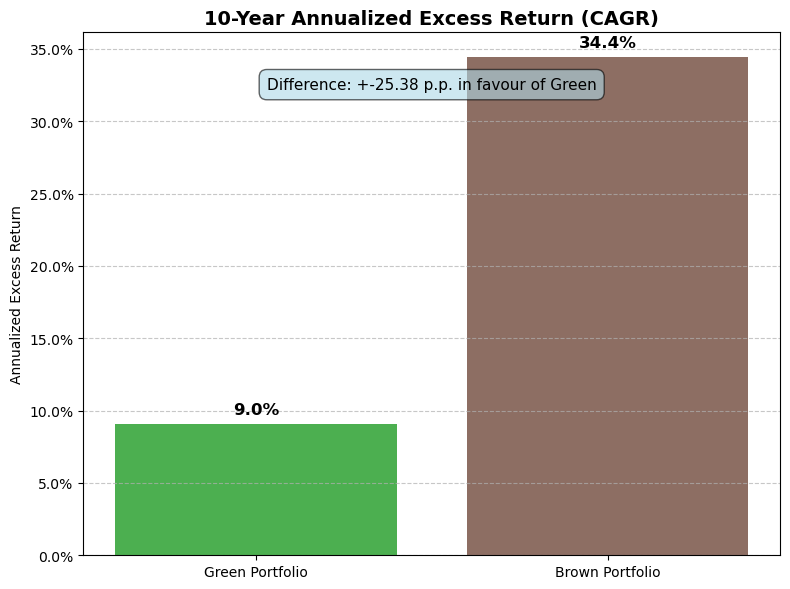

In [4]:
# --- Visualization Setup ---
portfolio_names = list(cagr_results.keys())
cagr_values = [cagr_results[name] for name in portfolio_names]

# Calculate the difference for the label
diff_value = cagr_values[0] - cagr_values[1] # Green - Brown

# --- Create the Chart ---
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(portfolio_names, cagr_values, color=['#4CAF50', '#8D6E63']) # Green and Brown colors

# --- Formatting ---
ax.set_title('10-Year Annualized Excess Return (CAGR)', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Excess Return')

# Format y-axis ticks as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.grid(axis='y', linestyle='--', alpha=0.7)

# --- Data Labels (Exact Percentages) ---
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, # Position label slightly above the bar
            f'{yval:.1%}', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# --- Difference Label ---
ax.text(
    0.5, 0.9, # Positioning near the top center
    f'Difference: +{diff_value*100:.2f} p.p. in favour of Green',
    transform=ax.transAxes, # Use axis coordinates (0 to 1)
    ha='center', va='center',
    bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", alpha=0.6),
    fontsize=11
)

plt.tight_layout()
plt.show()


# line chart

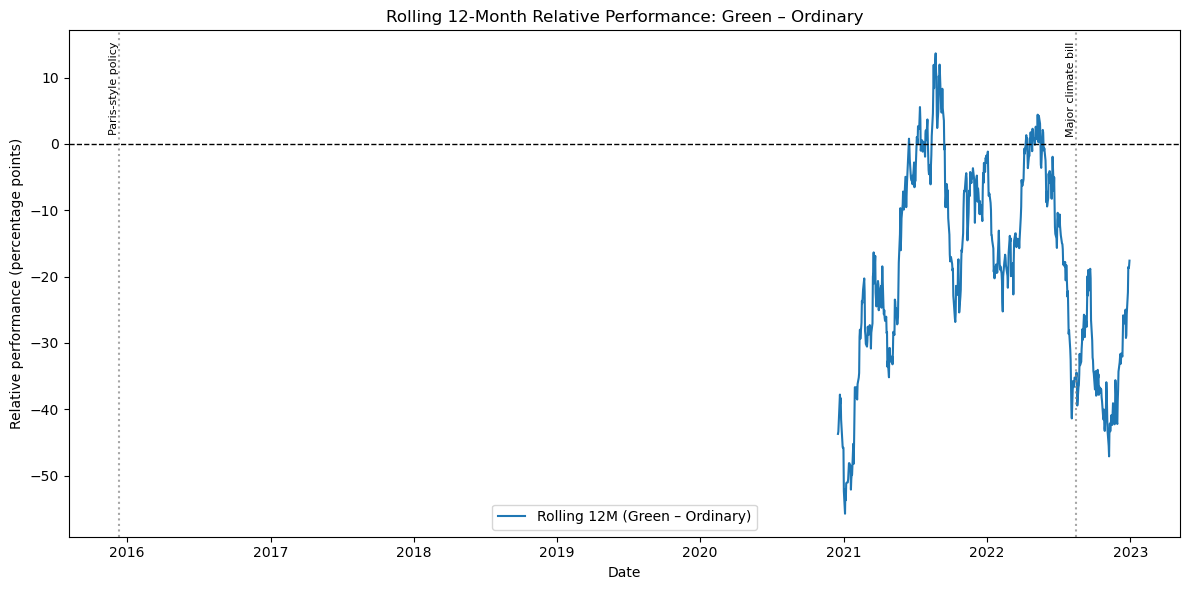

In [7]:
# If WINDOW not defined earlier, fall back to 252 trading days
if 'WINDOW' not in globals():
    WINDOW = 252

# Determine daily returns from either an index series (pct_change), an existing returns series,
# or fall back to the 'portfolio_returns' DataFrame if available (common case in this notebook).
# green_ret / brown_ret should be pandas Series of returns (not prices).
if 'green_index' in globals():
    # green_index assumed to be a price/index series -> convert to returns
    green_ret = green_index.pct_change()
elif 'green_returns' in globals():
    green_ret = green_returns
elif 'portfolio_returns' in globals() and 'Green_Portfolio' in portfolio_returns.columns:
    # portfolio_returns here contains daily returns already
    green_ret = portfolio_returns['Green_Portfolio']
else:
    raise NameError(
        "Neither 'green_index' nor 'green_returns' nor 'portfolio_returns[\"Green_Portfolio\"]' found. "
        "Define one of them before running this cell."
    )

if 'brown_index' in globals():
    brown_ret = brown_index.pct_change()
elif 'brown_returns' in globals():
    brown_ret = brown_returns
elif 'portfolio_returns' in globals() and 'Brown_Portfolio' in portfolio_returns.columns:
    brown_ret = portfolio_returns['Brown_Portfolio']
else:
    raise NameError(
        "Neither 'brown_index' nor 'brown_returns' nor 'portfolio_returns[\"Brown_Portfolio\"]' found. "
        "Define one of them before running this cell."
    )

# Ensure we have float dtype and aligned datetime index, drop initial NaNs from pct_change if present
green_ret = pd.to_numeric(green_ret).astype(float)
brown_ret = pd.to_numeric(brown_ret).astype(float)

# Align indices
common_idx = green_ret.index.intersection(brown_ret.index)
green_ret = green_ret.reindex(common_idx).dropna()
brown_ret = brown_ret.reindex(common_idx).dropna()

# Compute rolling WINDOW returns (geometric). Use (1 + r).rolling(...).apply(prod) - 1
green_12m = (1 + green_ret).rolling(WINDOW, min_periods=WINDOW).apply(lambda x: x.prod() - 1)
brown_12m = (1 + brown_ret).rolling(WINDOW, min_periods=WINDOW).apply(lambda x: x.prod() - 1)

# Relative performance: Green – Brown
gmb_12m = green_12m - brown_12m   # "green minus brown"

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(gmb_12m.index, gmb_12m * 100, label="Rolling 12M (Green – Ordinary)")

plt.axhline(0, color="black", linewidth=1, linestyle="--")

# Example: overlay a few policy event dates (replace with your actual dates)
policy_events = {
    "Paris-style policy": "2015-12-12",
    "Major climate bill": "2022-08-16"
}

# compute ylim once for placement
ymin, ymax = plt.ylim()
for label, d in policy_events.items():
    d = pd.to_datetime(d)
    plt.axvline(d, color="grey", linestyle=":", alpha=0.7)
    plt.text(d, ymax * 0.9, label, rotation=90, va="top", ha="right", fontsize=8)

plt.title("Rolling 12‑Month Relative Performance: Green – Ordinary")
plt.ylabel("Relative performance (percentage points)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/00/c54qzf757tzdyqs5hr4n94vc0000gn/T/ipykernel_35484/2832340948.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  policy_rate = policy_rate.reindex(gmb_12m.index).fillna(method='ffill').fillna(method='bfill').fillna(0.0)


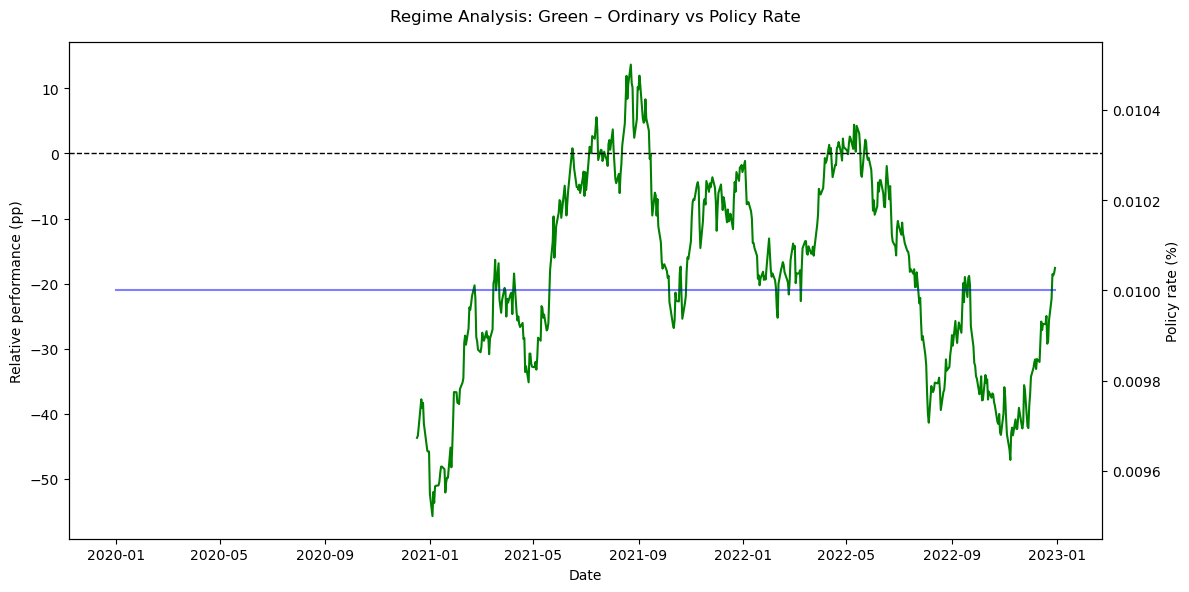

In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(gmb_12m.index, gmb_12m * 100, color="green", label="Rolling 12M (Green – Ordinary)")
ax1.axhline(0, color="black", linewidth=1, linestyle="--")
ax1.set_ylabel("Relative performance (pp)")
ax1.set_xlabel("Date")

# Ensure 'policy_rate' exists. If not, try sensible fallbacks.
if 'policy_rate' not in globals():
	# Prefer using rf_aligned (if available) as a proxy, converting to percent
	if 'rf_aligned' in globals():
		policy_rate = rf_aligned * 100
	else:
		# Last resort: create a zero series aligned to gmb_12m index
		policy_rate = pd.Series(0.0, index=gmb_12m.index)

# Align policy_rate to the gmb_12m index for plotting and fill any missing values
policy_rate = policy_rate.reindex(gmb_12m.index).fillna(method='ffill').fillna(method='bfill').fillna(0.0)

ax2 = ax1.twinx()
ax2.plot(policy_rate.index, policy_rate, color="blue", alpha=0.5, label="Policy rate")
ax2.set_ylabel("Policy rate (%)")

fig.suptitle("Regime Analysis: Green – Ordinary vs Policy Rate")
fig.tight_layout()
plt.show()
